# KEYS Take Away

- Structure of ARIMA
  +  Mô hình được áp dụng trên các chuỗi đặc thù có yếu tố thời gian. Một mô hình chuỗi thời gian thường dự báo dựa trên giả định rằng các qui luật trong quá khứ sẽ lặp lại ở tương lai. Chúng ta đang mô hình hóa mối quan hệ trong quá khứ giữa biến độc lập (biến đầu vào) và biến phụ thuộc (biến mục tiêu). Dựa vào mối quan hệ này để dự đoán giá trị trong tương lai của biến phụ thuộc.<br>
  <br>
  + Những qui luật đặc trưng như : yếu tố chu kỳ, mùa vụ và yếu tố xu hướng.
  <br>
  
  + Trend
  + Seasonality
  + Cyclicality(repeating pattern but no fixed period)
  + White nose(series of measurement, where each value is uncorrelated with previous value - ex:flipping coin)
  + Stationarity(distribution of data doesn't change with time). 3 criteria to fulfill:
      - zero trend, isn't growing or shrinking
      - variance is constant (the avg distance of data points from zero line isnt changing)
      - autocorrelation is constant (how each value in time series related to its neighbors stays the same)

  + Making time series stationary
      - augemented dicky_fuller test if our time series is non-stationary
      - Split dataset
  

<br> - Fit ARIMA model
<br> - Optimize model
- Make forecasts
- Calculate Uncertainty in predictions


# Libraries

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima #func to compute sarima model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from math import sqrt
from pandas import concat
from datetime import datetime
from matplotlib import pyplot
from keras.models import Sequential
from numpy import concatenate, asarray
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')


# COFFEE Data

In [3]:
#Read coffee data & preprocessing data
coffee_df = pd.read_excel('coffee_data.xlsx',index_col='Ngày',
            parse_dates= ['Ngày'])

In [4]:
# Resample to daily frequency and forward-fill missing values
coffee_df = coffee_df.resample('D').ffill()
# Reset the index
coffee_df = coffee_df.reset_index()

In [5]:
coffee_df

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0
...,...,...
864,2023-05-15,55566.5
865,2023-05-16,56066.5
866,2023-05-17,56666.5
867,2023-05-18,57000.0


In [6]:
coffee_df.head()

,Ngày,Giá Cà Phê
0,2021-01-01,31667.5
1,2021-01-02,31667.5
2,2021-01-03,31667.5
3,2021-01-04,32717.0
4,2021-01-05,32417.0


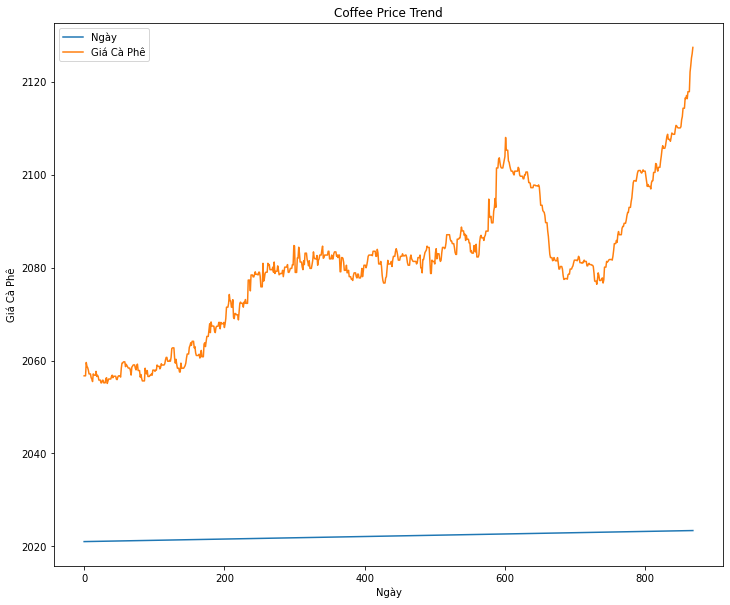

In [7]:
#Trend
fig, ax = plt.subplots(figsize=(12, 10))
coffee_df.plot(ax=ax)
plt.xlabel('Ngày')
plt.ylabel('Giá Cà Phê')
plt.title('Coffee Price Trend')
plt.show()

# Feature engineering 

## Khởi tạo chuỗi lợi suất và khảo sát dữ liệu

In [8]:
# Calculate the logarithmic return
r_t = np.log(coffee_df['Giá Cà Phê'] / coffee_df['Giá Cà Phê'].shift(1))

# # The first value of r_t will be NaN due to the shift operation, so you might want to drop it
# r_t = r_t.dropna()

In [9]:
r_t

0           NaN
1      0.000000
2      0.000000
3      0.032604
4     -0.009212
         ...   
864    0.028291
865    0.008958
866    0.010645
867    0.005868
868    0.008734
Name: Giá Cà Phê, Length: 869, dtype: float64

In [10]:
#Fill giá trị np.nan bằng trung bình chuỗi.
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

0    0.000687
1    0.000000
2    0.000000
3    0.032604
4   -0.009212
Name: Giá Cà Phê, dtype: float64

In [11]:
#Bieu do loi suat

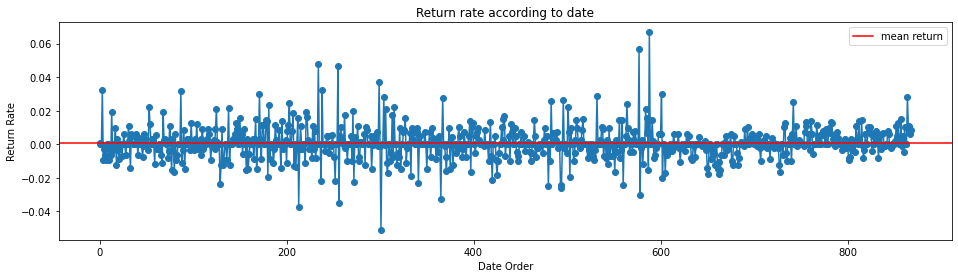

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

In [13]:
# Nhan xet: 

In [14]:
# Quan he tuyen tinh giua rt va rt-1

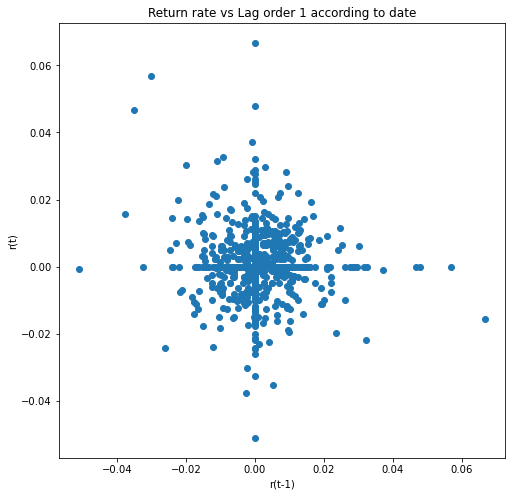

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

Text(0, 0.5, 'frequency')

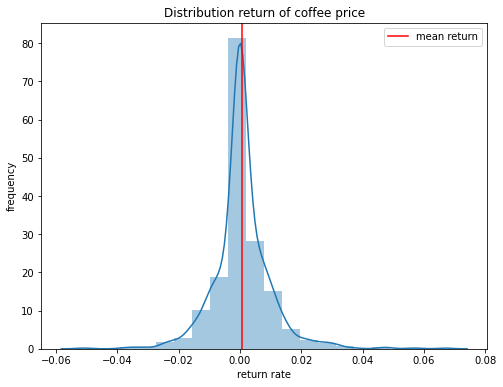

In [16]:
import seaborn as sns

plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of coffee price')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

Từ biểu đồ ta kết luận 2 chuỗi có phân phối tương tự nhau nếu như các điểm trên đồ thì nằm trên một đường thẳng. Khi đó 
có thể được coi như là một phân phối chuẩn. Cách kiểm định phân phối chuẩn dựa trên biểu đồ qqplot

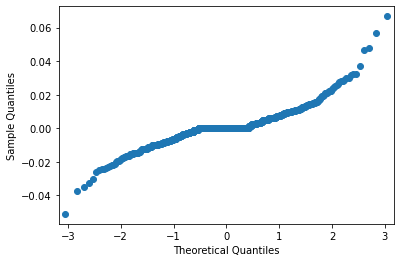

In [17]:
#c1
import statsmodels.api as sm
sm.qqplot(r_t)
plt.show()

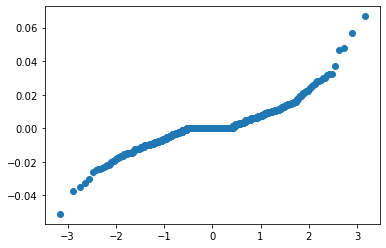

In [18]:
#c2
from scipy import stats
tq = stats.probplot(r_t)
plt.scatter(x=tq[0][0], y = tq[0][1])
plt.show()

## Kiểm tra tính dừng (stationarity?)

In [19]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
    
#0th element test statistic: -27
    # more negative means more likely to be stationary
    
#1st element is test p-value: 0.
    # if p-value is < 0.05 -> reject null hypothesis -> reject non-stationary -> must be stationary
    
#4th element is the critical test statistics (dictionary) equate to different p-values
    # if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.86

ADF Statistic: -22.583191
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


# Xây dựng mô hình

<Figure size 576x432 with 0 Axes>

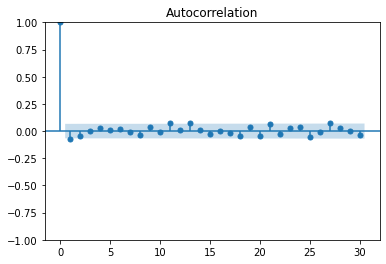

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

Đối với bài toán này toàn bộ các hệ số tự tương quan với bậc nhỏ hơn hoặc bằng 5 đều có giá trị nằm trong khoảng tin cậy 95% của 0. Do đó chúng ta có thể linh hoạt lựa chọn bậc *q* = 5
 là vị trí mà hệ số tự tương quan lớn nhất.

<Figure size 576x432 with 0 Axes>

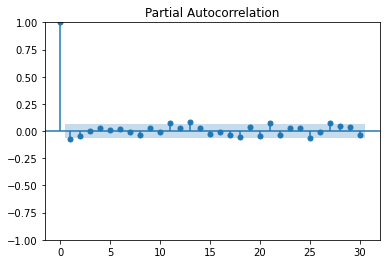

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

PACF sẽ có tác dụng tìm ra hệ số bậc tự do *p*
 của quá trình tự hồi qui *AR(p)*
. Tương tự như ACF, thông qua một biểu đồ PACF về giá trị các hệ số tương quan riêng phần tương ứng với các độ trễ khác nhau, chúng ta sẽ tìm ra được các bậc tự do *p*
 phù hợp. Đó chính là vị trí mà giá trị của hệ số tương quan riêng phần nằm ngoài ngưỡng tin cậy 95% của giả thuyết hệ số tương quan riêng phần bằng 0.

Tương tự như ACF, bậc của PACF cũng thường nhỏ hơn 5. Như vậy ta cũng có thể lựa chọn bậc tự do của PACF là một giá trị nào đó từ 1 đến 5. Kết hợp giữa bậc của *p*
 và *q*
 và giá trị của *d = 0*
 do chuỗi *rt* 
 đã là một chuỗi dừng ta có thể thu được một số kịch bản

ARIMA(2, 0, 2)
ARIMA(2, 0, 0)
ARIMA(5, 0, 0)
ARIMA(0, 0, 5)

# Chỉ số AIC - Akaike Information Criteria
- giá trị của AIC càng nhỏ thì mô hình của chúng ta càng phù hợp.

## Đọc hiểu kết quả mô hình ARIMA.

In [22]:
from statsmodels.tsa.arima.model import ARIMA

def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

In [23]:
orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5)]
models = _arima_fit(orders, r_t)

ARIMA(2,0,2) --> AIC=-5631.005925402081; BIC=-5602.401866650488
ARIMA(2,0,0) --> AIC=-5634.518806208165; BIC=-5615.449433707104
ARIMA(5,0,0) --> AIC=-5629.364185915878; BIC=-5595.99278403902
ARIMA(0,0,5) --> AIC=-5629.4854349937905; BIC=-5596.114033116933


Ta nhận thấy mô hình ARIMA(2,0,0) là phù hợp nhất với bộ dữ liệu lợi suất vì nó tương ứng với chỉ số AIC là nhỏ nhất.

## Phương pháp Auto ARIMA

In [24]:
model = auto_arima(r_t, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5629.410, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-5631.165, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5631.487, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5629.919, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-5630.590, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5628.455, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5634.852, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5631.994, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5633.252, Time=0.54 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5634.366, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5634.412, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5632.258, Time=0.25 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 2.639 seconds
-5634.852105758942


Trong trường hợp mô hình có yếu tố mùa vụ thì ta sẽ cần thiết lập seasonal = True và kết hợp thêm chu kì của mùa vụ. Chẳng hạn chu kì là 7 ngay thì có thể khai báo D = 7. Khi đó mô hình ARIMA sẽ trở thành mô hình SARIMA (seasonal ARIMA).
<br>
<br>Kết quả mô hình tốt nhất thu được là ARIMA(0, 0, 1):

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  869
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2820.426
Date:                Sun, 20 Aug 2023   AIC                          -5634.852
Time:                        06:17:25   BIC                          -5620.550
Sample:                             0   HQIC                         -5629.379
                                - 869                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.213      0.027    7.82e-05       0.001
ma.L1         -0.0747      0.028     -2.623      0.009      -0.131      -0.019
sigma2      8.873e-05   2.18e-06     40.735      0.000    8.45e-05     9.3e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1986.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 # Kiếm tra yếu tố mùa vụ

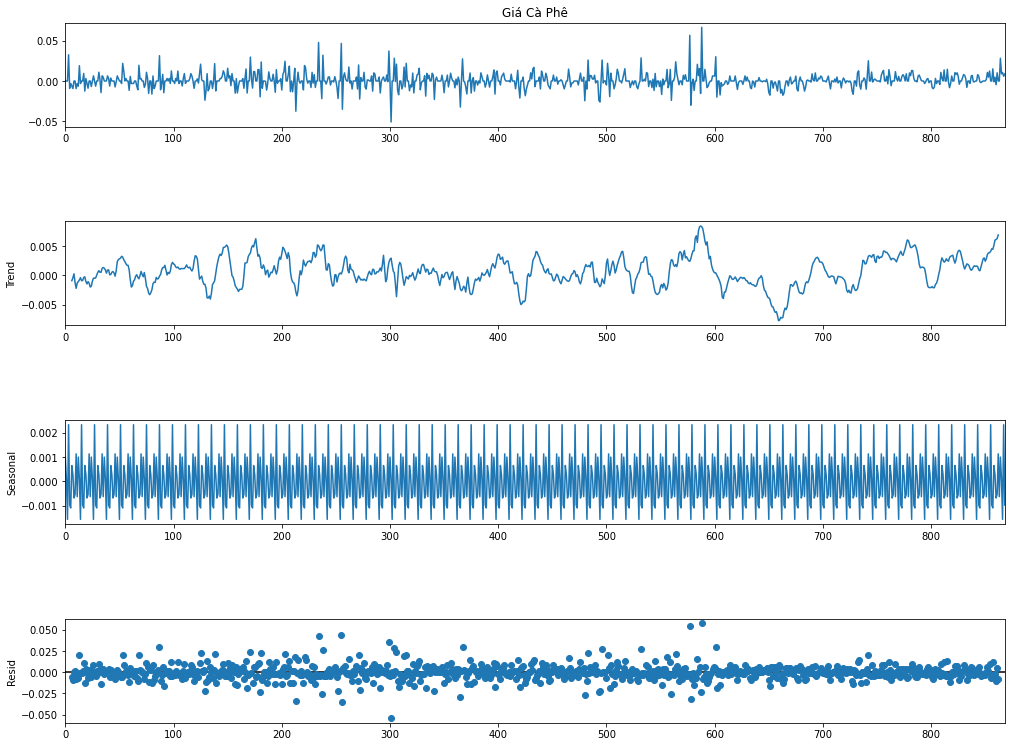

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(r_t, period = 12)
fig = result.plot()
fig.set_size_inches(16, 12)

# ---------- Split data ----------

In [27]:

# r_t is our return series
split_index = int(len(r_t) * 0.8)  # Split at 80% of the data

# Split the data into training and testing sets
train = r_t[:split_index]
test = r_t[split_index:]

print('Train shape:', train.shape)
print('Test shape:', test.shape)



Train shape: (695,)
Test shape: (174,)


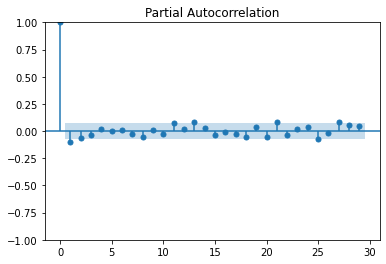

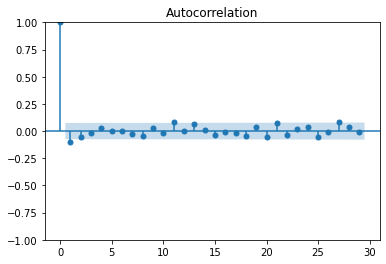

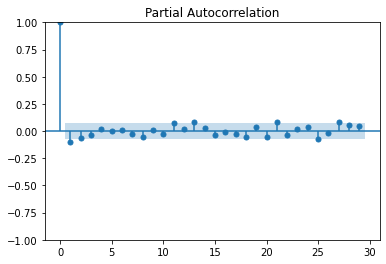

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(train)
plot_pacf(train)

Từ biểu đồ ta có thể lựa chọn bậc tự tương quan riêng phần PACF và tự tương quan ACF là các giá trị nhỏ hơn hoặc bằng 5. Do chuỗi có trend nên chúng ta sẽ lấy sai phân bậc 1 để tạo chuỗi dừng, hay nói cách khác bậc của intergration *d = 1*
. Ngoài ra chúng ta cần phải xác định thêm các bậc *(P,D,Q)*
 của yếu tố mùa vụ được trích xuất từ chuỗi ban đầu. Để mô hình hiểu được chúng ta đang hồi qui trên mô hình SARIMA thì cần thiết lập tham số *seasonal=True* và chu kì của mùa vụ *m=12*. Chiến lược stepwise sẽ tự động tìm cho ta một mô hình tốt nhất dựa trên tham số đã thiết lập.

In [29]:
model_sarima = auto_arima(train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_sarima.aic())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3271.268, Time=0.39 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3744.323, Time=1.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3521.889, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3829.299, Time=3.05 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3598.818, Time=1.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3907.573, Time=2.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3821.637, Time=2.45 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.98 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3966.703, Time=4.20 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [33]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  695
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 12)   Log Likelihood                2069.302
Date:                             Sun, 20 Aug 2023   AIC                          -4124.605
Time:                                     06:12:44   BIC                          -4092.929
Sample:                                          0   HQIC                         -4112.346
                                             - 695                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1287      0.037     -3.498      0.000      -0.201      -0.057
ar.L2          0.0198      0.038      0.518      0.604      -0.055       0.095
ar.L3         -0.0453      0.038     -1.195      0.232      -0.120       0.029
ma.L1         -0.9883      0.015    -66.926      0.000      -1.017      -0.959
ar.S.L12      -0.6718      0.030    -22.221      0.000      -0.731      -0.613
ar.S.L24      -0.3377      0.031    -10.904      0.000      -0.398      -0.277
sigma2         0.0001   4.89e-06     26.958      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               186.56
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.34
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Day là mô hình SARIMA(p=3, d=1, q=1)(p=2, D=1, q=0, m=12). Mô hình cho kết quả khá tốt khi các hệ số hồi qui đều có ý nghĩa thống kê (toàn bộ cột P>|z| đều nhỏ hơn 0.05).

# Prediction

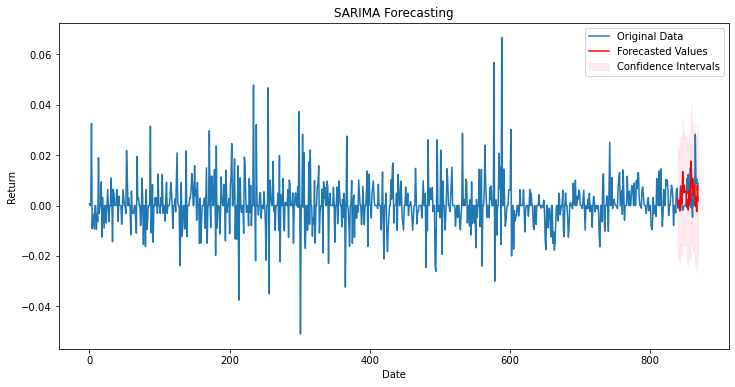

In [31]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Best SARIMA parameters obtained from auto_arima
best_sarima_order = (3, 1, 1)
best_seasonal_order = (2, 1, 0, 12)

# Fit the SARIMA model to the entire dataset
model = SARIMAX(r_t, order=best_sarima_order, seasonal_order=best_seasonal_order)
fitted_model = model.fit()

# Forecast future values for the next 1 month (30 days)
forecast_steps = 30
forecast = fitted_model.get_forecast(steps=forecast_steps)

# Get the forecasted values and confidence intervals compatible with the 'test' dataset
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate the index for the forecast period in the original 'r_t' array
forecast_index = r_t.index[-forecast_steps:]

# Plot the original data, forecasted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(r_t.index, r_t.values, label='Original Data')
plt.plot(forecast_index, forecast_values, color='red', label='Forecasted Values')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.xlabel('Date') #Ngày
plt.ylabel('Return') #Giá Cà Phê
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()


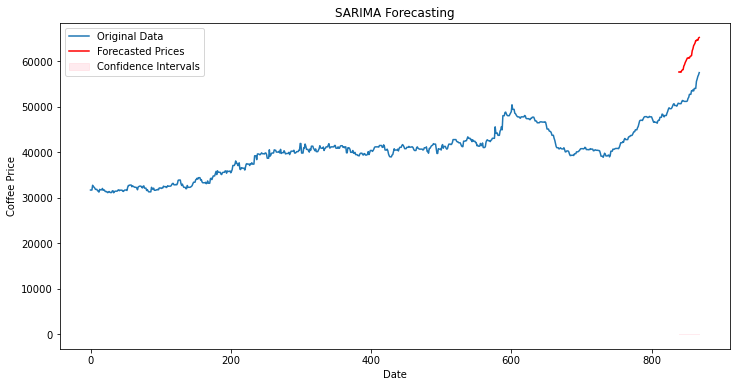

In [38]:
# Convert forecasted return series back to coffee prices
forecast_prices = coffee_df['Giá Cà Phê'].iloc[-1] * np.exp(np.cumsum(forecast_values))

# Ensure that forecast_prices and actual_prices have the same index
forecast_prices.index = actual_prices.index

# Plot the original data, forecasted values, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(coffee_df.index, coffee_df['Giá Cà Phê'].values, label='Original Data')
plt.plot(actual_prices.index, forecast_prices, color='red', label='Forecasted Prices')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.xlabel('Date')  # Ngày
plt.ylabel('Coffee Price')  # Giá Cà Phê
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()


In [39]:
actual_prices

839    50716.5
840    50666.5
841    50666.5
842    50666.5
843    51066.5
844    51366.5
845    51316.5
846    51216.5
847    51166.5
848    51166.5
849    51166.5
850    51166.5
851    51266.5
852    51816.5
853    52066.5
854    52716.5
855    52716.5
856    52716.5
857    53516.5
858    53466.5
859    53716.5
860    53466.5
861    54016.5
862    54016.5
863    54016.5
864    55566.5
865    56066.5
866    56666.5
867    57000.0
868    57500.0
Name: Giá Cà Phê, dtype: float64

In [40]:
forecast_prices

839    57636.241213
840    57605.948672
841    57712.408033
842    57587.783490
843    57939.101368
844    58101.726183
845    58146.113070
846    58932.878776
847    59236.534800
848    59718.878137
849    60029.207996
850    60361.356929
851    60706.616842
852    60667.247855
853    60804.810339
854    60699.244487
855    61053.867327
856    61143.582386
857    61229.615909
858    62319.517369
859    62738.978720
860    63421.950159
861    63685.208697
862    64014.491529
863    64546.715706
864    64532.305562
865    64753.482654
866    64600.251749
867    65110.464610
868    65232.766388
Name: predicted_mean, dtype: float64

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def _measure_metric(y, yhat):
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, yhat)
    
    non_zero_actual = y[y > 1e-6]  # Adjust the threshold as needed
    non_zero_mape = np.abs((y - yhat) / non_zero_actual)
    mape = np.mean(non_zero_mape) * 100
    
    return mse, rmse, mae, mape

In [42]:
# Calculate evaluation metrics
mse, rmse, mae, mape = _measure_metric(actual_prices, forecast_prices)

# Display evaluation metrics
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)

Mean Squared Error: 70295836.54961744
Root Mean Squared Error: 8384.261240539767
Mean Absolute Error: 8320.243231775321
Mean Absolute Percentage Error: 15.748344263346054


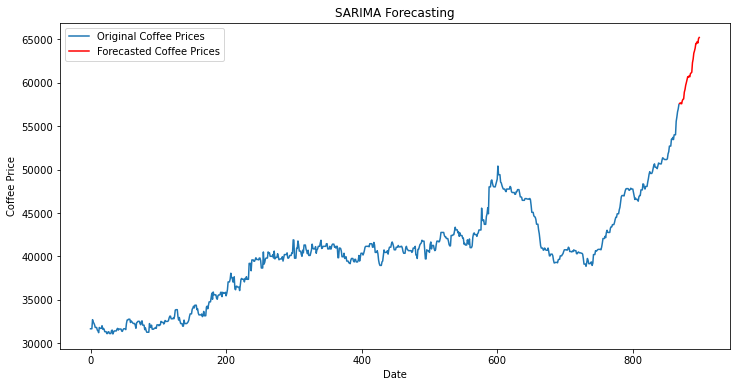

In [44]:
# Convert the forecasted return series back to coffee prices
forecasted_prices = coffee_df['Giá Cà Phê'].iloc[-1] * np.exp(np.cumsum(forecast_values))

# Plot the original data and forecasted coffee prices
plt.figure(figsize=(12, 6))
plt.plot(coffee_df.index, coffee_df['Giá Cà Phê'], label='Original Coffee Prices')
plt.plot(forecasted_prices.index, forecasted_prices, color='red', label='Forecasted Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()


# Ver2

In [45]:
#training and test set
training = r_t.iloc[:-31]  # Up to 31 days before the end of the data
testing = r_t.iloc[-31:]  # Last 31 days of the data

In [50]:
training.shape

(838,)

In [49]:
testing.shape

(31,)

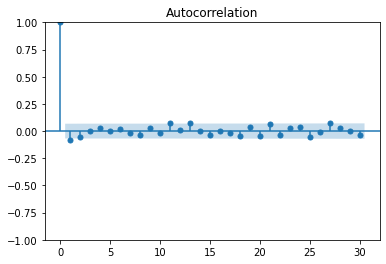

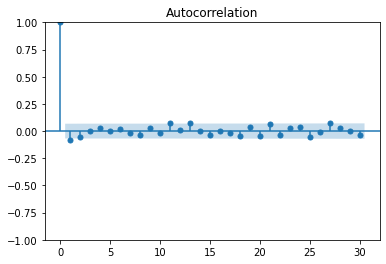

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(training)

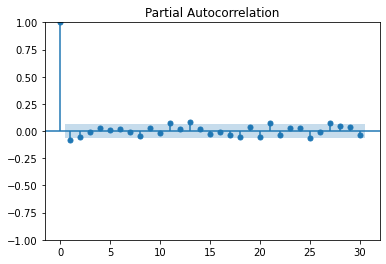

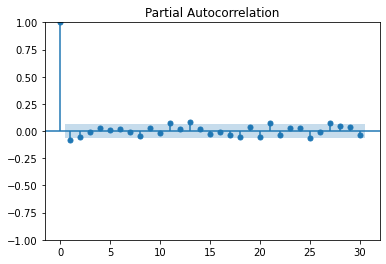

In [52]:
plot_pacf(training)

In [53]:
model_sarima = auto_arima(training, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model_sarima.aic())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-4080.419, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-4632.682, Time=1.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-4369.774, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-4734.620, Time=2.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-4469.733, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-4834.250, Time=2.77 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-4732.121, Time=1.26 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.57 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-4900.507, Time=4.15 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

In [54]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  838
Model:             SARIMAX(5, 1, 1)x(0, 1, 1, 12)   Log Likelihood                2608.614
Date:                            Sun, 20 Aug 2023   AIC                          -5201.227
Time:                                    06:57:27   BIC                          -5163.504
Sample:                                         0   HQIC                         -5186.757
                                            - 838                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2340      0.060     -3.869      0.000      -0.353      -0.115
ar.L2         -0.1422      0.061     -2.323      0.020      -0.262      -0.022
ar.L3         -0.1785      0.053     -3.363      0.001      -0.283      -0.074
ar.L4         -0.0608      0.052     -1.166      0.243      -0.163       0.041
ar.L5          0.0066      0.045      0.147      0.883      -0.082       0.095
ma.L1         -0.8019      0.057    -13.956      0.000      -0.915      -0.689
ma.S.L12      -0.8791      0.021    -41.265      0.000      -0.921      -0.837
sigma2         0.0001   3.12e-06     32.669      0.000    9.57e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):               669.99
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.47
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Fit SARIMA model and make predictions
def fit_sarima_model(train_data, order, seasonal_order):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted_model = model.fit(disp=-1)
    return fitted_model

# Forecast coffee prices for the next 31 days
def forecast_sarima(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast


In [57]:
# Best SARIMA parameters obtained from auto_arima
best_sarima_order = (5, 1, 1)
best_seasonal_order = (0, 1, 1, 12)

In [58]:
# Fit the SARIMA model
sarima_model = fit_sarima_model(training, best_sarima_order, best_seasonal_order)

In [59]:
# Forecast future values for the next 1 month (30 days)
forecast_steps = 31

# Forecast coffee prices for the next 31 days (Test set)
forecast_test = forecast_sarima(sarima_model, steps=forecast_steps)

# Convert forecast_test to pandas Series with the correct index
forecast_test_series = pd.Series(forecast_test)
forecast_test_series.index = testing.index

# Print the forecasted prices for the next 31 days (Test set)
print("Forecasted Coffee Prices for the Next 31 Days (Test Set):")
print(forecast_test_series)

Forecasted Coffee Prices for the Next 31 Days (Test Set):
838    0.002694
839    0.000898
840    0.003673
841    0.002567
842   -0.000016
843    0.003225
844    0.001149
845    0.000772
846    0.002360
847    0.002094
848    0.001339
849    0.002205
850    0.002696
851    0.001065
852    0.003935
853    0.002561
854    0.000021
855    0.003274
856    0.001207
857    0.000824
858    0.002411
859    0.002146
860    0.001391
861    0.002257
862    0.002748
863    0.001117
864    0.003987
865    0.002613
866    0.000073
867    0.003326
868    0.001259
Name: predicted_mean, dtype: float64


In [89]:
testing

838    0.006918
839   -0.000985
840   -0.000986
841    0.000000
842    0.000000
843    0.007864
844    0.005858
845   -0.000974
846   -0.001951
847   -0.000977
848    0.000000
849    0.000000
850    0.000000
851    0.001952
852    0.010671
853    0.004813
854    0.012407
855    0.000000
856    0.000000
857    0.015062
858   -0.000935
859    0.004665
860   -0.004665
861    0.010234
862    0.000000
863    0.000000
864    0.028291
865    0.008958
866    0.010645
867    0.005868
868    0.008734
Name: Giá Cà Phê, dtype: float64

In [71]:
# Assuming you have calculated r_t as above
import numpy as np

# Convert the logarithmic returns back to normal prices
previous_price = coffee_df['Giá Cà Phê'].shift(1)  # Previous prices
predicted_price = previous_price * np.exp(forecast_test_series)    # Calculated predicted prices

# Now you can create a new column in the DataFrame for the predicted prices
coffee_df['Predicted_Price'] = predicted_price




In [72]:
coffee_df

,Ngày,Giá Cà Phê,Predicted_Price
0,2021-01-01,31667.5,NaN
1,2021-01-02,31667.5,NaN
2,2021-01-03,31667.5,NaN
3,2021-01-04,32717.0,NaN
4,2021-01-05,32417.0,NaN
...,...,...,...
864,2023-05-15,55566.5,54232.311738
865,2023-05-16,56066.5,55711.877917
866,2023-05-17,56666.5,56070.618692
867,2023-05-18,57000.0,56855.290099


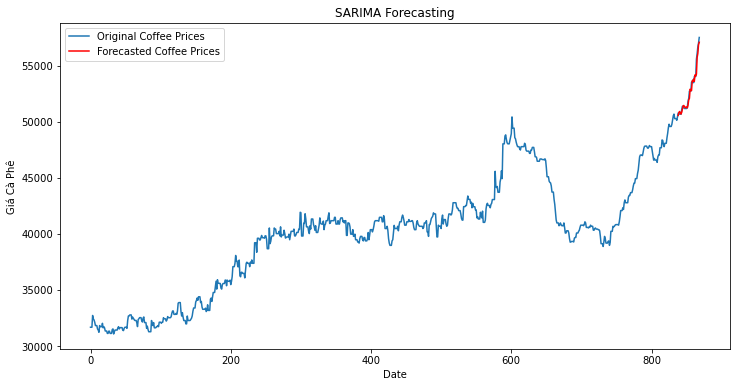

In [74]:
# Plot the original data and forecasted coffee prices
plt.figure(figsize=(12, 6))
plt.plot(coffee_df.index, coffee_df['Giá Cà Phê'], label='Original Coffee Prices')
plt.plot(coffee_df.index, coffee_df['Predicted_Price'], color='red', label='Forecasted Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Giá Cà Phê')
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()

In [82]:
predicted = coffee_df['Predicted_Price'].iloc[-31:]

In [85]:
predicted

838    50552.508279
839    50812.130695
840    50903.139914
841    50796.745171
842    50665.713443
843    50830.171513
844    51125.211592
845    51406.151646
846    51437.726642
847    51323.873435
848    51235.074039
849    51279.457757
850    51304.622756
851    51220.996148
852    51468.646404
853    51949.363544
854    52067.615429
855    52889.378123
856    52780.167098
857    52759.931505
858    53645.694205
859    53581.364841
860    53791.296451
861    53587.325012
862    54165.134579
863    54076.844942
864    54232.311738
865    55711.877917
866    56070.618692
867    56855.290099
868    57071.810042
Name: Predicted_Price, dtype: float64

In [90]:
actual

838    50766.5
839    50716.5
840    50666.5
841    50666.5
842    50666.5
843    51066.5
844    51366.5
845    51316.5
846    51216.5
847    51166.5
848    51166.5
849    51166.5
850    51166.5
851    51266.5
852    51816.5
853    52066.5
854    52716.5
855    52716.5
856    52716.5
857    53516.5
858    53466.5
859    53716.5
860    53466.5
861    54016.5
862    54016.5
863    54016.5
864    55566.5
865    56066.5
866    56666.5
867    57000.0
868    57500.0
Name: Giá Cà Phê, dtype: float64

In [92]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(actual_prices, predicted_prices):
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
    
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Percentage Error (MAPE):", mape)

# Assuming you have actual_prices and predicted_prices
# actual: Actual prices from your dataset
# predicted: Predicted prices obtained from your model

calculate_metrics(actual, predicted)


Mean Squared Error (MSE): 140496.92554076805
Root Mean Squared Error (RMSE): 374.82919515529744
Mean Absolute Error (MAE): 265.48971788769785
Mean Absolute Percentage Error (MAPE): 0.49499633721946257
